<a href="https://colab.research.google.com/github/JuliaKoryukova/Neural-Networks/blob/main/10_YOLO_object_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<font color='green' size='7'>**Использование YOLO v11 для задачи object detection**</font>  


**Датасет:**

Penn-Fudan Database for Pedestrian Detection and Segmentation

https://www.cis.upenn.edu/~jshi/ped_html/


**Описание плана работы**

1. Предсказание на всем датасете с помощью модели YOLOv11
3. Посчет метрики IoU для всех найденных bbox


# <font color='#11a642' size='6'> Импорт и установка библиотек

In [ ]:
!pip install -U albumentations

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 225.3/225.3 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 291.4/291.4 kB 22.0 MB/s eta 0:00:00
  Attempting uninstall: albucore
    Found existing installation: albucore 0.0.16
    Uninstalling albucore-0.0.16:
      Successfully uninstalled albucore-0.0.16
  Attempting uninstall: albumentations
    Found existing installation: albumentations 1.4.15
    Uninstalling albumentations-1.4.15:
      Successfully uninstalled albumentations-1.4.15


In [ ]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 877.1/877.1 kB 24.1 MB/s eta 0:00:00


In [ ]:
import pandas as pd
from ultralytics import YOLO
import torch
from torchvision.io import read_image
from torchvision.ops import masks_to_boxes
import matplotlib.pyplot as plt
import os
import re
import numpy as np
from PIL import Image, ImageDraw
from torchvision import transforms
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset, Dataset
from pathlib import Path
import xml.etree.ElementTree as ET
import cv2
import csv
import matplotlib.patches as patches
import shutil
import random
import glob

# <font color='#11a642' size='6'> Загрузка и просмотр датасета

In [ ]:
!wget https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip -P data
!cd data && unzip PennFudanPed.zip

--2024-10-24 11:42:13--  https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip
Resolving www.cis.upenn.edu (www.cis.upenn.edu)... 158.130.69.163, 2607:f470:8:64:5ea5::d
Connecting to www.cis.upenn.edu (www.cis.upenn.edu)|158.130.69.163|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 53723336 (51M) [application/zip]
Saving to: ‘data/PennFudanPed.zip’

PennFudanPed.zip    100%[===================>]  51.23M  31.1MB/s    in 1.6s    

2024-10-24 11:42:15 (31.1 MB/s) - ‘data/PennFudanPed.zip’ saved [53723336/53723336]

Archive:  PennFudanPed.zip
   creating: PennFudanPed/
  inflating: PennFudanPed/added-object-list.txt  
   creating: PennFudanPed/Annotation/
  inflating: PennFudanPed/Annotation/FudanPed00001.txt  
  inflating: PennFudanPed/Annotation/FudanPed00002.txt  
  inflating: PennFudanPed/Annotation/FudanPed00003.txt  
  inflating: PennFudanPed/Annotation/FudanPed00004.txt  
  inflating: PennFudanPed/Annotation/FudanPed00005.txt  
  inflating: PennFudanPe

In [ ]:
# Путь к директориям с изображениями и аннотациями
image_dir = '/content/data/PennFudanPed/PNGImages'
annotation_dir = '/content/data/PennFudanPed/Annotation'
predictions_dir = '/content/data/PennFudanPed/Predictions'
os.makedirs(predictions_dir, exist_ok=True)

# <font color='#11a642' size='6'> Подготовка данных

Структура данных для YOLO

In [ ]:
# Создаю каталоги для хранения данных
!mkdir -p /content/data/PennFudanPed/dataset/images/train
!mkdir -p /content/data/PennFudanPed/dataset/images/val
!mkdir -p /content/data/PennFudanPed/dataset/labels/train
!mkdir -p /content/data/PennFudanPed/dataset/labels/val

In [ ]:
# Разделю изображения на тренировочные и валидационные (80/20)
# Получаем список изображений и аннотаций
images = sorted(os.listdir(image_dir))
annotations = sorted(os.listdir(annotation_dir))

# Смешиваю изображения и аннотации, чтобы разделить их случайным образом
data = list(zip(images, annotations))
random.shuffle(data)

# 80% для обучения, 20% для валидации
split_idx = int(len(data) * 0.8)
train_data = data[:split_idx]
val_data = data[split_idx:]

# Перемещение файлов в соответствующие каталоги
for img, ann in train_data:
    shutil.copy(os.path.join(image_dir, img), '/content/data/PennFudanPed/dataset/images/train/')
    shutil.copy(os.path.join(annotation_dir, ann), '/content/data/PennFudanPed/dataset/labels/train/')

for img, ann in val_data:
    shutil.copy(os.path.join(image_dir, img), '/content/data/PennFudanPed/dataset/images/val/')
    shutil.copy(os.path.join(annotation_dir, ann), '/content/data/PennFudanPed/dataset/labels/val/')

In [ ]:
# Конвертация аннотаций в формат YOLO
# <class_id> <x_center> <y_center> <width> <height>
def convert_to_yolo_format(bbox, img_width, img_height):
    x_min, y_min, x_max, y_max = bbox

    x_center = (x_min + x_max) / 2 / img_width
    y_center = (y_min + y_max) / 2 / img_height
    width = (x_max - x_min) / img_width
    height = (y_max - y_min) / img_height

    return [x_center, y_center, width, height]

In [ ]:
# Функция для получения размера изображения
def get_image_size(image_path):
    with Image.open(image_path) as img:
        width, height = img.size
    return width, height

In [ ]:
def process_annotation_file(annotation_file, image_file, output_dir, class_id=0):
    img_width, img_height = get_image_size(image_file)

    with open(annotation_file, 'r') as f:
        lines = f.readlines()

    output_lines = []
    for line in lines:
        if 'Bounding box' in line:
            parts = line.split(':')[-1].strip().split('-')
            x_min, y_min = map(int, parts[0].strip().strip('()').split(','))
            x_max, y_max = map(int, parts[1].strip().strip('()').split(','))

            bbox = convert_to_yolo_format([x_min, y_min, x_max, y_max], img_width, img_height)
            output_lines.append(f"{class_id} " + " ".join(map(str, bbox)))

    output_file = os.path.join(output_dir, os.path.basename(annotation_file).replace('.txt', '.txt'))
    with open(output_file, 'w') as f:
        f.write("\n".join(output_lines))

In [ ]:
output_label_dir = '/content/data/PennFudanPed/dataset/labels/train'

for annotation_file in os.listdir(annotation_dir):
    image_file = os.path.join('/content/data/PennFudanPed/PNGImages', annotation_file.replace('.txt', '.png'))
    process_annotation_file(os.path.join(annotation_dir, annotation_file), image_file, output_label_dir)

In [ ]:
%%writefile dataset.yaml

train: /content/data/PennFudanPed/dataset/images/train
val: /content/data/PennFudanPed/dataset/images/val

nc: 1  # Количество классов (если только один класс — человек)
names: ['person']  # Название класса

Writing dataset.yaml


# <font color='#11a642' size='6'> Предсказание с помощью YOLOv11

Train

In [ ]:
!yolo task=detect mode=train model=yolo11n.pt data=/content/dataset.yaml epochs=50 batch=32 imgsz=640

100% 5.35M/5.35M [00:00<00:00, 105MB/s]
Ultralytics 8.3.21 🚀 Python-3.10.12 torch-2.5.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolo11n.pt, data=/content/dataset.yaml, epochs=50, time=None, patience=100, batch=32, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labe

In [ ]:
# Инициализация модели YOLO
model = YOLO('yolo11n.pt')


image 1/1 /content/data/PennFudanPed/PNGImages/FudanPed00004.png: 640x640 3 persons, 1 sports ball, 8.4ms
Speed: 5.2ms preprocess, 8.4ms inference, 586.3ms postprocess per image at shape (1, 3, 640, 640)


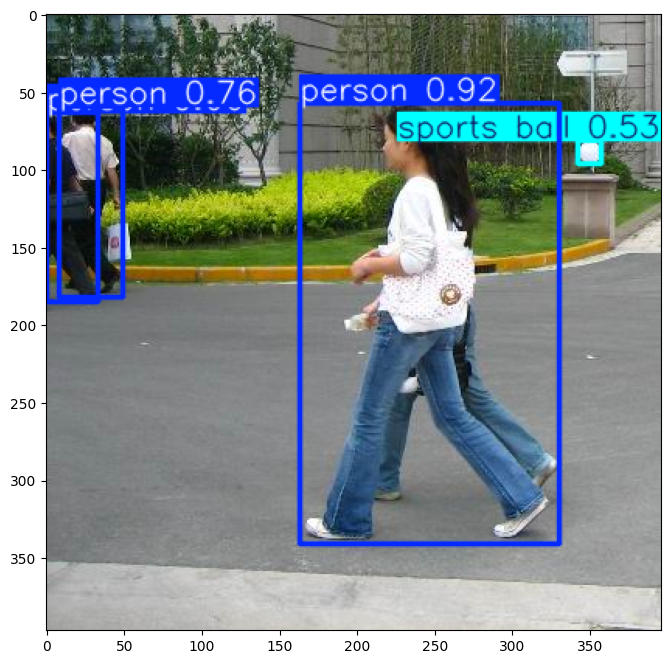

In [ ]:
detections = model.predict('/content/data/PennFudanPed/PNGImages/FudanPed00004.png')

# отрисовка результата
plt.figure(figsize=(10, 8))
plt.imshow(detections[0].plot()[:, :, ::-1]);

In [ ]:
detections = model.predict(
    source=image_dir,
    conf=0.5,  # порог уверенности модели
    iou=0.7,  # порог IOU для отсеивания лишних боксов
    verbose=True,  # выводить служебное инфо о процессе и результате детекции
    save=True,  # сохранить результат детекции на диск
    save_txt=False,  # сохранить результаты детекции в текстовом файле
    save_conf=False,  # сохранять уверенность модели в результатах детекции
    # device=DEVICE,  # текущий девайс (если не указать то сам выбирает CUDA если доступен)
    )


image 1/170 /content/data/PennFudanPed/PNGImages/FudanPed00001.png: 640x640 2 persons, 9.8ms
image 2/170 /content/data/PennFudanPed/PNGImages/FudanPed00002.png: 608x640 1 person, 1 backpack, 47.6ms
image 3/170 /content/data/PennFudanPed/PNGImages/FudanPed00003.png: 608x640 1 person, 8.9ms
image 4/170 /content/data/PennFudanPed/PNGImages/FudanPed00004.png: 640x640 3 persons, 1 sports ball, 10.0ms
image 5/170 /content/data/PennFudanPed/PNGImages/FudanPed00005.png: 640x640 3 persons, 9.7ms
image 6/170 /content/data/PennFudanPed/PNGImages/FudanPed00006.png: 640x608 3 persons, 2 handbags, 1 suitcase, 48.9ms
image 7/170 /content/data/PennFudanPed/PNGImages/FudanPed00007.png: 480x640 6 persons, 45.6ms
image 8/170 /content/data/PennFudanPed/PNGImages/FudanPed00008.png: 640x576 4 persons, 1 handbag, 44.2ms
image 9/170 /content/data/PennFudanPed/PNGImages/FudanPed00009.png: 608x640 3 persons, 1 bicycle, 9.7ms
image 10/170 /content/data/PennFudanPed/PNGImages/FudanPed00010.png: 640x640 1 person,

In [ ]:
detections[0].boxes

ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0., 0.], device='cuda:0')
conf: tensor([0.9215, 0.9123], device='cuda:0')
data: tensor([[158.3370, 178.3717, 301.5593, 431.1234,   0.9215,   0.0000],
        [419.0504, 169.8206, 534.2167, 488.8239,   0.9123,   0.0000]], device='cuda:0')
id: None
is_track: False
orig_shape: (536, 559)
shape: torch.Size([2, 6])
xywh: tensor([[229.9481, 304.7476, 143.2223, 252.7517],
        [476.6335, 329.3223, 115.1662, 319.0034]], device='cuda:0')
xywhn: tensor([[0.4114, 0.5686, 0.2562, 0.4716],
        [0.8527, 0.6144, 0.2060, 0.5952]], device='cuda:0')
xyxy: tensor([[158.3370, 178.3717, 301.5593, 431.1234],
        [419.0504, 169.8206, 534.2167, 488.8239]], device='cuda:0')
xyxyn: tensor([[0.2833, 0.3328, 0.5395, 0.8043],
        [0.7496, 0.3168, 0.9557, 0.9120]], device='cuda:0')

In [ ]:
# Запишу в CSV файл предсказанные координаты bbox
# Все предсказаныи сохранены в этой папке
pred_folder = 'runs/detect/predict'
pred_image_files = os.listdir(pred_folder)  # Получаем список файлов изображений

# Записываю в CSV
with open('predicted_bboxes.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['image', 'xmin', 'ymin', 'xmax', 'ymax', 'confidence', 'class'])  # Заголовки

    for i, pred_file in enumerate(pred_image_files):
        pred_path = os.path.join(pred_folder, pred_file)

        if i < len(detections):
            bboxes = detections[i].boxes.xyxy.cpu().numpy()  # Перемещаем тензор на CPU перед преобразованием в NumPy
            confs = detections[i].boxes.conf.cpu().numpy()
            classes = detections[i].boxes.cls.cpu().numpy()

        for bbox, conf, cls in zip(bboxes, confs, classes):
            writer.writerow([pred_file, *bbox.tolist(), conf, cls])

In [ ]:
# Загрузка предсказанных координат из CSV файла
pred_bboxes = {}
with open('predicted_bboxes.csv', mode='r') as file:
    reader = csv.reader(file)
    next(reader)  # Пропустить заголовок
    for row in reader:
        image = row[0]
        bbox = list(map(float, row[1:5]))  # xmin, ymin, xmax, ymax

        if image not in pred_bboxes:
            pred_bboxes[image] = []
        pred_bboxes[image].append(bbox)

# Пример вывода предсказанных bounding boxes
for image, bboxes in pred_bboxes.items():
    print(f"Image: {image}, Bounding Boxes: {bboxes}")

Image: PennPed00017.jpg, Bounding Boxes: [[158.33700561523438, 178.37168884277344, 301.55926513671875, 431.1234130859375], [419.0504455566406, 169.82057189941406, 534.2166748046875, 488.8239440917969]]
Image: PennPed00062.jpg, Bounding Boxes: [[65.96856689453125, 91.37100219726562, 190.81687927246094, 383.5227355957031], [159.89332580566406, 142.48532104492188, 229.7537841796875, 248.92538452148438]]
Image: FudanPed00053.jpg, Bounding Boxes: [[287.364501953125, 123.04168701171875, 446.5486755371094, 421.2302551269531]]
Image: PennPed00043.jpg, Bounding Boxes: [[163.50054931640625, 57.446250915527344, 330.5459289550781, 341.3119201660156], [8.57568645477295, 59.274410247802734, 49.03095626831055, 182.0818328857422], [0.0, 63.37519836425781, 33.74647903442383, 185.58616638183594], [342.85577392578125, 81.71122741699219, 357.273193359375, 96.33014678955078]]
Image: FudanPed00012.jpg, Bounding Boxes: [[184.57254028320312, 53.850120544433594, 321.8587646484375, 335.8963928222656], [1.033262

In [ ]:
print("Predicted BBoxes after writing to CSV:")
with open('predicted_bboxes.csv', mode='r') as file:
    for line in file:
        print(line.strip())

Predicted BBoxes after writing to CSV:
image,xmin,ymin,xmax,ymax,confidence,class
PennPed00017.jpg,158.33700561523438,178.37168884277344,301.55926513671875,431.1234130859375,0.9214819,0.0
PennPed00017.jpg,419.0504455566406,169.82057189941406,534.2166748046875,488.8239440917969,0.9122842,0.0
PennPed00062.jpg,65.96856689453125,91.37100219726562,190.81687927246094,383.5227355957031,0.879759,0.0
PennPed00062.jpg,159.89332580566406,142.48532104492188,229.7537841796875,248.92538452148438,0.5405584,24.0
FudanPed00053.jpg,287.364501953125,123.04168701171875,446.5486755371094,421.2302551269531,0.9351446,0.0
PennPed00043.jpg,163.50054931640625,57.446250915527344,330.5459289550781,341.3119201660156,0.9161877,0.0
PennPed00043.jpg,8.57568645477295,59.274410247802734,49.03095626831055,182.0818328857422,0.76319367,0.0
PennPed00043.jpg,0.0,63.37519836425781,33.74647903442383,185.58616638183594,0.6599889,0.0
PennPed00043.jpg,342.85577392578125,81.71122741699219,357.273193359375,96.33014678955078,0.5274

Сравнение с истинными координатами

In [ ]:
# Функция для парсинга аннотационного файла
def parse_annotation(annotation_path):
    true_bboxes = []
    with open(annotation_path, 'r') as f:
        lines = f.readlines()
    for i, line in enumerate(lines):
        if "Bounding box" in line:
            # Extract coordinates from format: (Xmin, Ymin) - (Xmax, Ymax) : (160, 182) - (302, 431)
            coords = line.split(":")[1].strip()
            # Разделяем на две пары координат
            first_pair, second_pair = coords.split("-")
            # Очищаем и извлекаем первую пару координат
            first_pair = first_pair.replace("(", "").replace(")", "").strip()
            xmin, ymin = map(int, first_pair.split(","))
            # Очищаем и извлекаем вторую пару координат
            second_pair = second_pair.replace("(", "").replace(")", "").strip()
            xmax, ymax = map(int, second_pair.split(","))
            true_bboxes.append([xmin, ymin, xmax, ymax])
    return np.array(true_bboxes)

In [ ]:
# Словарь для хранения истинных bbox для каждого изображения
true_bboxes = {}

# Проход по всем аннотационным файлам в папке
for annotation_file in os.listdir(annotation_dir):
    if annotation_file.endswith('.txt'):
        # Получаем путь к файлу аннотации
        annotation_path = os.path.join(annotation_dir, annotation_file)

        # Парсим файл аннотации и извлекаем bbox
        bboxes = parse_annotation(annotation_path)

        # Извлекаем имя изображения
        image_name = annotation_file.replace('.txt', '.png')

        # Сохраняем bounding boxes для изображения
        true_bboxes[image_name] = bboxes  # Добавляем в словарь

# Вывод всех истинных bounding boxes
for image, bboxes in true_bboxes.items():
    print(f"Image: {image}, BBoxes: {bboxes}")

Image: PennPed00032.png, BBoxes: [[ 98  50 203 329]]
Image: PennPed00060.png, BBoxes: [[ 43  23 142 326]
 [189  21 283 230]
 [117  28 191 226]
 [273  81 389 327]
 [378  31 476 330]]
Image: PennPed00086.png, BBoxes: [[  8  33 109 253]
 [208  49 306 318]
 [345  32 457 325]
 [ 73 163 180 353]
 [113  65 164 197]]
Image: PennPed00044.png, BBoxes: [[ 71  36 170 329]
 [253  63 336 282]
 [332  54 408 276]
 [181  76 225 193]]
Image: PennPed00051.png, BBoxes: [[ 38  52 203 326]
 [314  67 481 365]
 [459  34 587 373]
 [554  67 628 339]]
Image: PennPed00073.png, BBoxes: [[ 98  38 191 326]
 [182  46 277 340]
 [316  51 413 331]]
Image: PennPed00053.png, BBoxes: [[ 15  29 124 325]
 [169  27 266 329]]
Image: FudanPed00063.png, BBoxes: [[ 29  38 114 332]
 [156  42 262 329]
 [312  54 330  99]
 [297  54 303  73]
 [305  53 310  73]]
Image: PennPed00061.png, BBoxes: [[ 34  17 143 307]
 [250  57 275 146]]
Image: PennPed00003.png, BBoxes: [[  8  33 174 365]
 [452  64 531 353]
 [531  91 661 381]]
Image: PennPe

In [ ]:
print("Predicted BBoxes keys:", pred_bboxes.keys())
print("True BBoxes keys:", true_bboxes.keys())

Predicted BBoxes keys: dict_keys(['PennPed00017.jpg', 'PennPed00062.jpg', 'FudanPed00053.jpg', 'PennPed00043.jpg', 'FudanPed00012.jpg', 'FudanPed00042.jpg', 'PennPed00019.jpg', 'FudanPed00024.jpg', 'PennPed00038.jpg', 'PennPed00076.jpg', 'PennPed00065.jpg', 'FudanPed00065.jpg', 'PennPed00059.jpg', 'PennPed00011.jpg', 'PennPed00089.jpg', 'FudanPed00039.jpg', 'PennPed00021.jpg', 'FudanPed00035.jpg', 'PennPed00088.jpg', 'PennPed00049.jpg', 'FudanPed00021.jpg', 'PennPed00022.jpg', 'FudanPed00022.jpg', 'PennPed00092.jpg', 'FudanPed00055.jpg', 'PennPed00045.jpg', 'FudanPed00020.jpg', 'PennPed00073.jpg', 'FudanPed00073.jpg', 'FudanPed00060.jpg', 'PennPed00003.jpg', 'PennPed00080.jpg', 'PennPed00029.jpg', 'FudanPed00050.jpg', 'PennPed00004.jpg', 'PennPed00035.jpg', 'FudanPed00025.jpg', 'PennPed00093.jpg', 'FudanPed00027.jpg', 'FudanPed00061.jpg', 'PennPed00063.jpg', 'FudanPed00008.jpg', 'PennPed00036.jpg', 'PennPed00006.jpg', 'FudanPed00015.jpg', 'PennPed00008.jpg', 'PennPed00026.jpg', 'PennPe

In [ ]:
def show_image_with_bboxes(image_name, true_bboxes, pred_bboxes):
    img_path = os.path.join(image_dir, image_name)
    img = cv2.imread(img_path)

    if img is None:
        print(f"Could not load image at {img_path}")
        return

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(10, 10))
    plt.imshow(img)

    # Отображение истинных bboxes
    if image_name in true_bboxes:
        for bbox in true_bboxes[image_name]:
            if len(bbox) == 4:  # Убедитесь, что длина bbox равна 4
                xmin, ymin, xmax, ymax = bbox
                plt.gca().add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                                    edgecolor='green', facecolor='none', linewidth=2))

    # Отображение предсказанных bboxes
    if image_name in pred_bboxes:
        for bbox in pred_bboxes[image_name]:
            if len(bbox) == 4:  # Убедитесь, что длина bbox равна 4
                xmin, ymin, xmax, ymax = bbox
                plt.gca().add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                                    edgecolor='red', facecolor='none', linewidth=2))

    plt.axis('off')
    plt.show()

Showing: PennPed00017.png


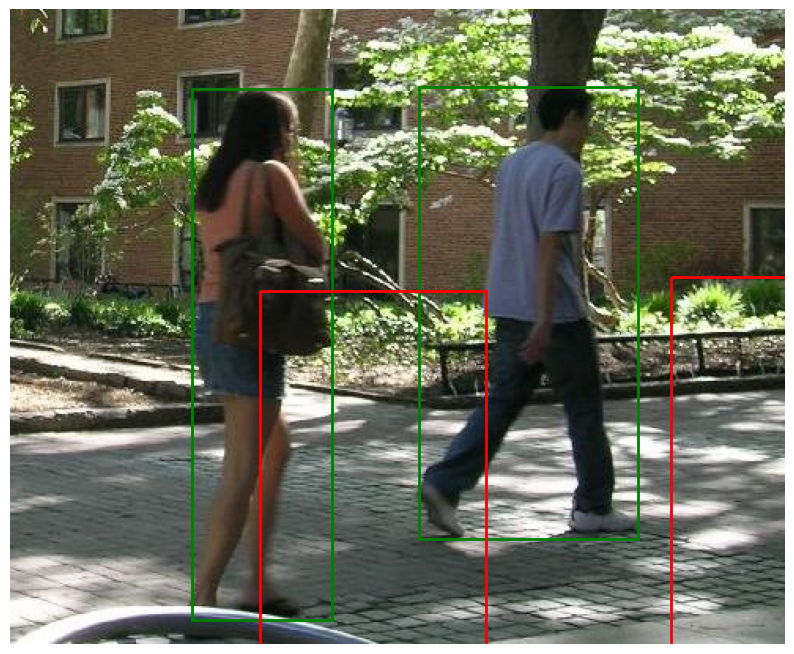

Showing: PennPed00062.png


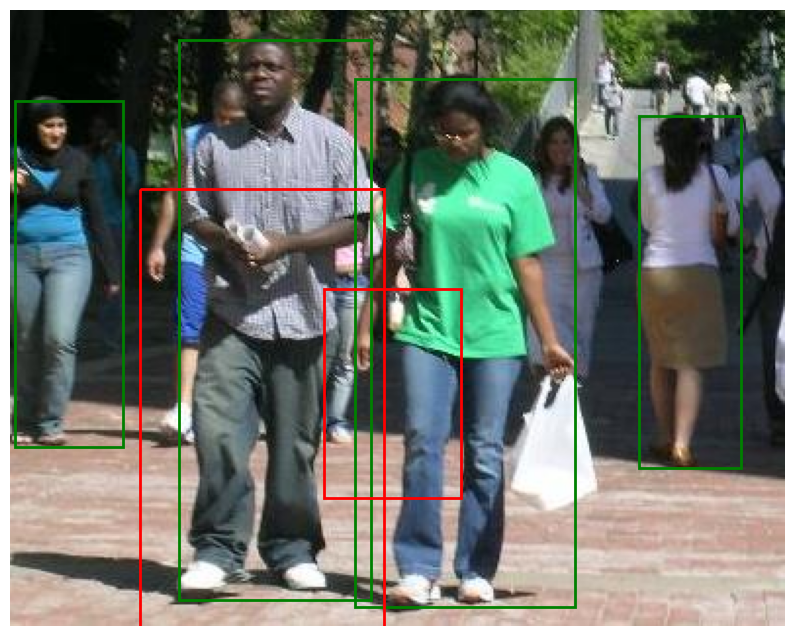

Showing: FudanPed00053.png


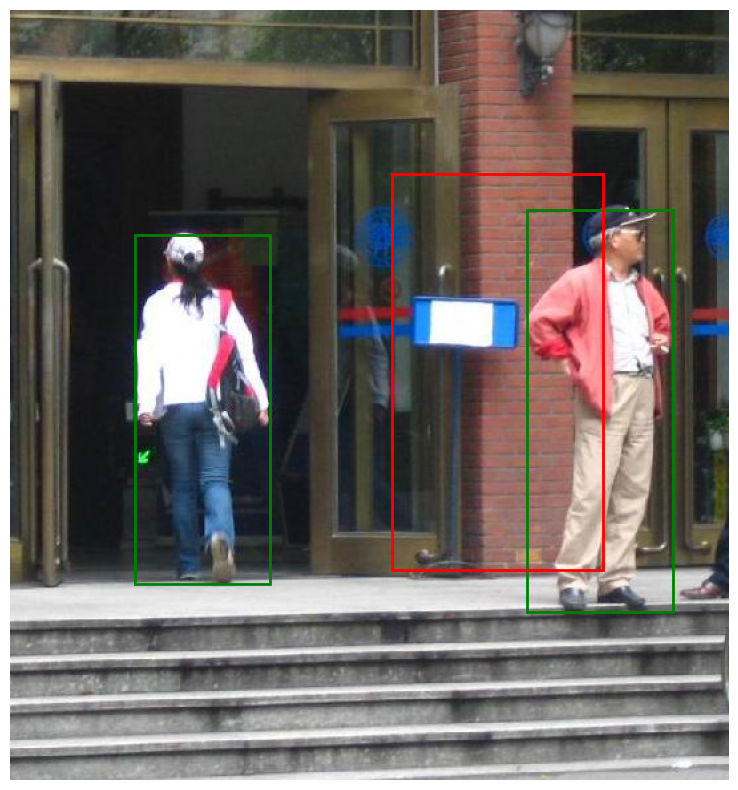

In [ ]:
# Подготовим правильные имена файлов
true_bboxes_png = {key.replace('.jpg', '.png'): value for key, value in true_bboxes.items()}
pred_bboxes_png = {key.replace('.jpg', '.png'): value for key, value in pred_bboxes.items()}

# Проверим, какие изображения доступны
valid_images = [img for img in list(pred_bboxes_png.keys())[:3] if img in os.listdir(image_dir)]

# Теперь можем отображать изображения
for image in valid_images:
    print(f"Showing: {image}")
    show_image_with_bboxes(image, true_bboxes_png, pred_bboxes_png)

In [ ]:
# Выводим количество предсказанных и истинных bounding boxes для первых 5 изображений
for i, image_name in enumerate(list(true_bboxes_png.keys())[:5]):
    true_count = len(true_bboxes_png[image_name])
    pred_count = len(pred_bboxes_png.get(image_name, []))
    print(f"Image: {image_name}, True BBoxes: {true_count}, Pred BBoxes: {pred_count}")

Image: PennPed00032.png, True BBoxes: 1, Pred BBoxes: 1
Image: PennPed00060.png, True BBoxes: 5, Pred BBoxes: 7
Image: PennPed00086.png, True BBoxes: 5, Pred BBoxes: 6
Image: PennPed00044.png, True BBoxes: 4, Pred BBoxes: 1
Image: PennPed00051.png, True BBoxes: 4, Pred BBoxes: 2


# <font color='#11a642' size='6'> Подсчет метрики IoU для всех найденных bbox

IoU считается как отношение площади пересечения к площади объединения двух боксов

IoU = Area of Intersection / Area of Union



In [ ]:
# Функция для вычисления IoU (Intersection over Union)
def calculate_iou(box1, box2):
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])
    intersection = max(0, x2 - x1) * max(0, y2 - y1)
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])
    union = box1_area + box2_area - intersection
    return intersection / union if union > 0 else 0

In [ ]:
def evaluate_dataset(model, data_dir):
    image_dir = os.path.join(data_dir, 'PNGImages')
    annotation_dir = os.path.join(data_dir, 'Annotation')
    total_iou = 0
    total_boxes = 0
    results_per_image = {}

    # Процесс все изображения в директории
    for image_path in glob.glob(os.path.join(image_dir, '*.png')):
        # Получаем соответствующий файл аннотации
        base_name = os.path.basename(image_path)
        image_id = base_name.split('.')[0]
        annotation_path = os.path.join(annotation_dir, base_name.replace('.png', '.txt'))
        if not os.path.exists(annotation_path):
            print(f"Warning: No annotation file found for {base_name}")
            continue
        # Получаем ground truth боксы
        try:
            gt_boxes = parse_annotation(annotation_path)
        except Exception as e:
            print(f"Error parsing annotation file {annotation_path}: {str(e)}")
            continue
        # Получаем предсказания YOLO
        results = model(image_path)
        pred_boxes = []
        # Извлекаем только предсказания для класса "person" (обычно класс 0 в YOLO)
        for r in results:
            boxes = r.boxes
            for box in boxes:
                if box.cls == 0:  # класс "person"
                    x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()
                    pred_boxes.append([int(x1), int(y1), int(x2), int(y2)])
        # Вычисляем IoU для каждой пары боксов
        image_ious = []
        if len(pred_boxes) > 0 and len(gt_boxes) > 0:
            for gt_box in gt_boxes:
                # Для каждого ground truth бокса находим предсказанный бокс с максимальным IoU
                max_iou = 0
                for pred_box in pred_boxes:
                    iou = calculate_iou(gt_box, pred_box)
                    max_iou = max(max_iou, iou)

                image_ious.append(max_iou)
                total_iou += max_iou
                total_boxes += 1
        # Сохраняем результаты для этого изображения
        avg_image_iou = np.mean(image_ious) if image_ious else 0
        results_per_image[image_id] = {
            'iou': avg_image_iou,
            'gt_boxes': len(gt_boxes),
            'pred_boxes': len(pred_boxes)
        }
        print(f"Processed {image_id}: IoU = {avg_image_iou:.4f} (GT boxes: {len(gt_boxes)}, Pred boxes: {len(pred_boxes)})")
    # Вычисляем средний IoU по всему датасету
    mean_iou = total_iou / total_boxes if total_boxes > 0 else 0

    return mean_iou, results_per_image

In [ ]:
TP = 0
FP = 0
FN = 0

# Установим порог для IoU
iou_threshold = 0.5

for image, preds in pred_bboxes_png.items():
    true = true_bboxes_png.get(image, [])
    matched = [False] * len(true)

    for pred in preds:
        best_iou_value = 0
        best_index = -1

        for i, t in enumerate(true):
            current_iou = calculate_iou(pred, t)
            if current_iou > best_iou_value:
                best_iou_value = current_iou
                best_index = i

        if best_iou_value >= iou_threshold:
            TP += 1
            matched[best_index] = True
        else:
            FP += 1

    FN += matched.count(False)

# Подсчет Precision and Recall
precision = TP / (TP + FP) if (TP + FP) > 0 else 0
recall = TP / (TP + FN) if (TP + FN) > 0 else 0

print(f'TP: {TP}, FP: {FP}, FN: {FN}')
print(f'Precision: {precision}, Recall: {recall}')

TP: 55, FP: 688, FN: 368
Precision: 0.0740242261103634, Recall: 0.13002364066193853


In [ ]:
# Использование
model = YOLO('yolo11n.pt')
data_dir = '/content/data/PennFudanPed'
mean_iou, results = evaluate_dataset(model, data_dir)
print(f"\nMean IoU across dataset: {mean_iou:.4f}")

# Вывод детальной статистики
print("\nDetailed results:")
for image_id, result in results.items():
    print(f"{image_id}: IoU = {result['iou']:.4f} (GT: {result['gt_boxes']}, Pred: {result['pred_boxes']})")


image 1/1 /content/data/PennFudanPed/PNGImages/PennPed00087.png: 640x608 1 person, 10.6ms
Speed: 2.7ms preprocess, 10.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 608)
Processed PennPed00087: IoU = 0.8316 (GT boxes: 1, Pred boxes: 1)

image 1/1 /content/data/PennFudanPed/PNGImages/PennPed00066.png: 576x640 5 persons, 3 bicycles, 8.9ms
Speed: 1.9ms preprocess, 8.9ms inference, 1.2ms postprocess per image at shape (1, 3, 576, 640)
Processed PennPed00066: IoU = 0.9269 (GT boxes: 3, Pred boxes: 5)

image 1/1 /content/data/PennFudanPed/PNGImages/PennPed00002.png: 352x640 9 persons, 1 backpack, 2 handbags, 9.6ms
Speed: 1.4ms preprocess, 9.6ms inference, 1.1ms postprocess per image at shape (1, 3, 352, 640)
Processed PennPed00002: IoU = 0.9092 (GT boxes: 6, Pred boxes: 9)

image 1/1 /content/data/PennFudanPed/PNGImages/PennPed00005.png: 384x640 5 persons, 2 backpacks, 1 handbag, 9.7ms
Speed: 1.5ms preprocess, 9.7ms inference, 1.8ms postprocess per image at shape (1, 3, 384

Вывод:

Mean IoU across dataset: 0.9155

Модель хорошо распознает объекты (высокий IoU), но пропускает некоторые объекты (низкий recall), а так же у нее случаются ложные срабатывания (низкий precision).

